In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy
import numpy.ma as ma





# Exercise 1: Image inpainting

Load the image `img_bad.png` and restore it as well as you can.

**Remark**: if you use `L-BFGS` for image processing, it may be a good idea to set the tolerance to a low value i.e. to use the option `tol=10**-8` or something of that order

(-0.5, 511.5, 341.5, -0.5)

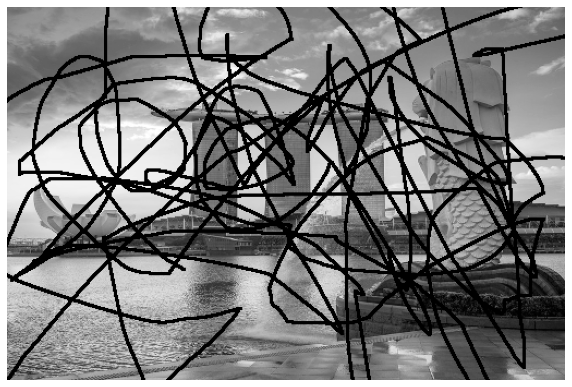

In [30]:
path_img = "/home/joycelim98/img_bad.png"
im = onp.array(imageio.imread(path_img).astype(float))/255.
plt.figure(figsize=(10,10))
plt.imshow(im,cmap="gray")
plt.axis("off")

## Problem statement
The observed image can be represented by a 342 x 512 matrix. Let $\textbf{X} \in \mathbb{R}^{342x512}$ represent this matrix.

Let the observed indices (i,j) $\in \Omega$ such that $\Omega$ is the set that contains the observed indices. Our goal is to find a $\textbf{Z} \in \mathbb{R}^{342x512}$ that approximates $\textbf{X}$ well. 

We will be using low rank matrices $\textbf{U}\in \mathbb{R}^{342xr}$ and $\textbf{V} \in \mathbb{R}^{rx512}$ such that $\textbf{Z} \approx \textbf{U}\textbf{V}$

Then the goal is to find a $\textbf{Z}_{*}$ that minimizes: $\frac{1}{2}\sum\limits_{(i,j)\in\Omega} (\textbf{X}_{ij}-\textbf{Z}_{ij})^2 + \lambda \lVert \textbf{Z} \rVert_{*}$, where $\lVert \textbf{Z} \rVert_{*}$ is the nuclear norm of $\textbf{Z}$


credit: http://www.jmlr.org/papers/volume11/mazumder10a/mazumder10a.pdf


We first find a mask array to only take into account the $(i,j) \in \Omega$, and we will be using $r=100$

In [61]:
im.shape #342 rows and 512 columns

(342, 512)

In [62]:
#to obtain mask for projection:
df2=pd.DataFrame(im.copy())
for i in range(512):
    df2[i] = df2[i].replace(0,np.nan) #replace 0 values with NaN
mask=onp.isnan(df2.to_numpy())
mask=onp.array(mask)
maskinv=(mask==False) #swap true and false values

In [63]:
r = 100
onp.random.seed(1)
U_init = onp.random.normal(0,1,size=(342,r)) / onp.sqrt(342*r)
V_init = onp.random.normal(0,1,size=(r,512)) / onp.sqrt(512*r)

# LFBGS

### We will try $\lambda = (0.001,0.01,0.1,0,1,0.5,10)$, and use n_iter=500, LBFGS_iter=1000

# $\lambda =0.001$

In [66]:
#lambda = 0.001
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 0.001*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [67]:
#let us define a function that does a few steps of LBFGS with U fixed
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(r,512)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(r,512)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                tol = 10**-8,
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    
    V_final = traj["x"].reshape(r,512)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(342,r)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(342,r)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                tol=10**-8,
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(342,r)
    return U_final




In [68]:
U,V = onp.copy(U_init), onp.copy(V_init)

In [69]:
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



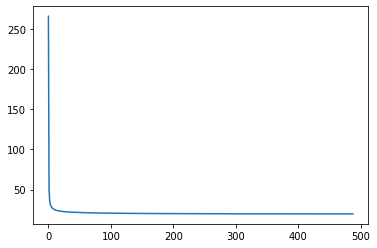

In [25]:
plt.plot(loss_history)

In [76]:
z3=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z3[i,j]=im[i,j]   #replace the observed indices with the actual observed values

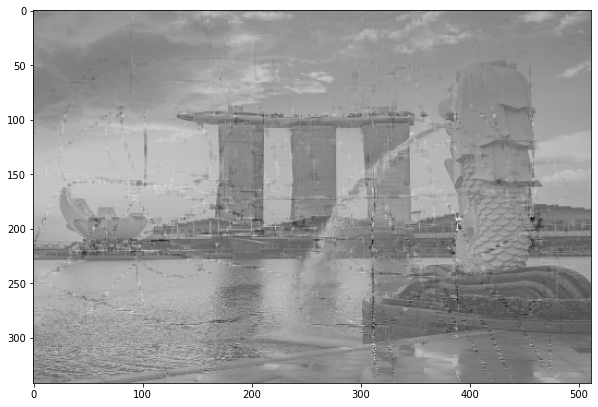

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(z3,cmap="gray")

# $\lambda=0.01$

In [79]:
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 0.01*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [90]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



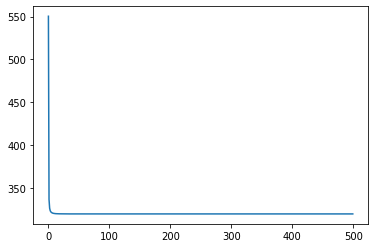

In [92]:
plt.plot(loss_history)

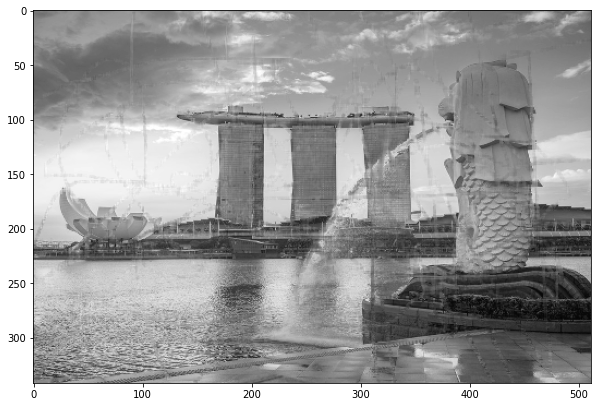

In [97]:
z6=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z6[i,j]=im[i,j]  

plt.figure(figsize=(10,10))
plt.imshow(z6,cmap="gray")

# $\lambda=0.1$

In [86]:
#lambda = 0.1
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 0.1*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [87]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))

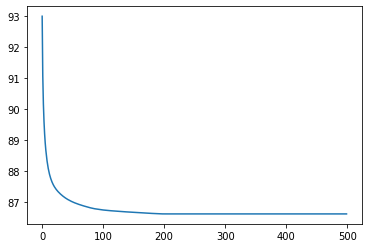

In [1198]:
plt.plot(loss_history)

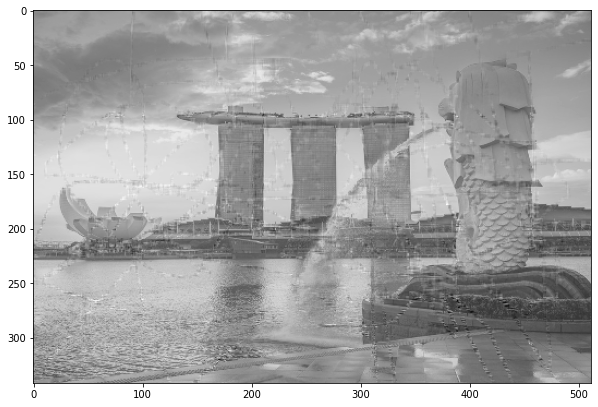

In [1199]:
z12=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z12[i,j]=im[i,j]  
plt.figure(figsize=(10,10))
plt.imshow(z12,cmap="gray") 

# $\lambda=0.5$

In [98]:
#lambda = 0.5 
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 0.5*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [99]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



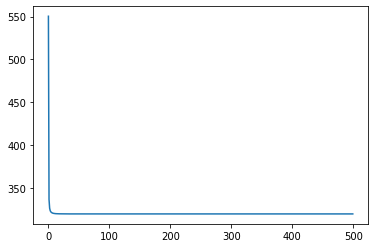

In [100]:
plt.plot(loss_history)

In [103]:
z9=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z9[i,j]=im[i,j]  

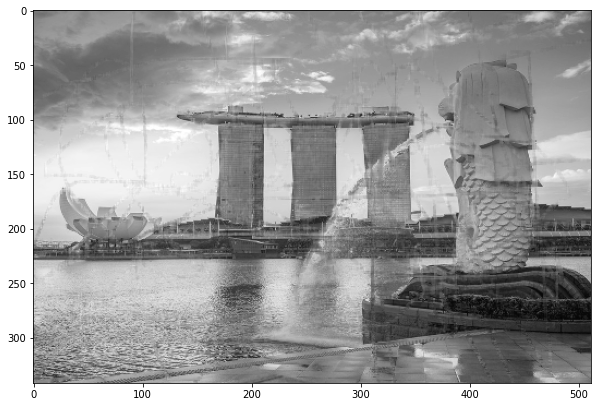

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(z9,cmap="gray") 

# $\lambda=0$

In [ ]:
#lambda =0
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) 

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [ ]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



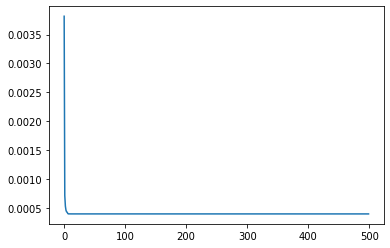

In [1053]:
plt.plot(loss_history)

In [1055]:
z1=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z1[i,j]=im[i,j]  
            

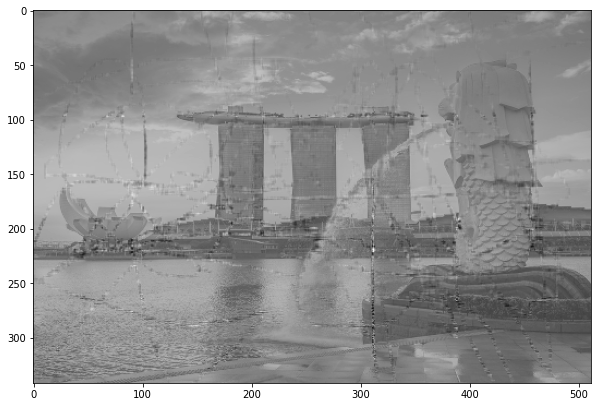

In [1058]:
plt.figure(figsize=(10,10))
plt.imshow(z1,cmap="gray")

# $\lambda=1$

In [ ]:
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 1*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [ ]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))

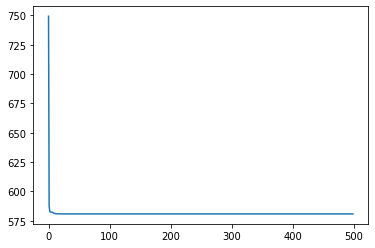

In [1177]:
plt.plot(loss_history)

In [1178]:
z8=U@V
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z8[i,j]=im[i,j]  

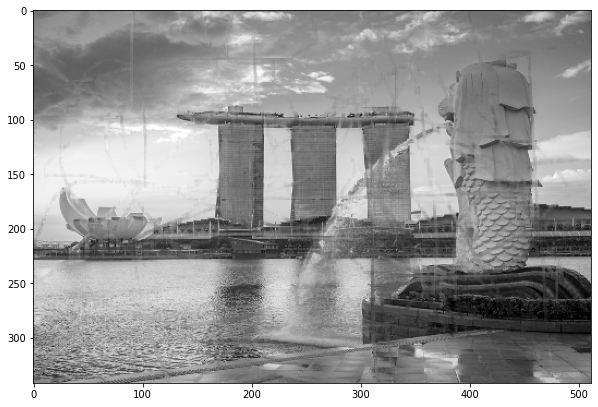

In [1179]:
plt.figure(figsize=(10,10))
plt.imshow(z8,cmap="gray") 

# $\lambda=10$

In [107]:
#lambda =10
def loss(U,V):
    return 0.5*np.sum(((im-U@V)[maskinv])**2) + 10*np.linalg.norm(U@V,ord="nuc")

grad_loss_u = jax.jit(jax.grad(loss,argnums=0))
grad_loss_v = jax.jit(jax.grad(loss,argnums=1))

In [108]:
U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 1000
n_iter = 500
loss_history=[]

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))



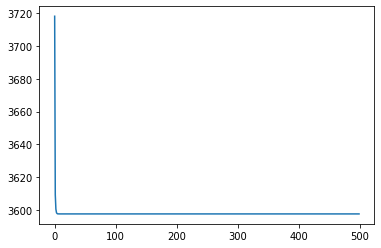

In [109]:
plt.plot(loss_history)

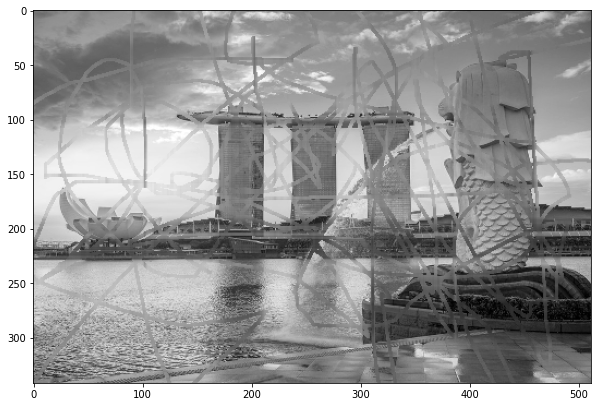

In [112]:
z7=U@V 
for i in range(342):
    for j in range(512):
        if mask[i,j]==False:
            z7[i,j]=im[i,j]  
plt.figure(figsize=(10,10))
plt.imshow(z7,cmap="gray") 

Cannot really compare the loss because no regularization had least loss but does not look as good as $\lambda =0.1$ or $\lambda =0.5$

$\lambda =0.5$ resulted in the picture that looked the most like it were the original, so our final image is:

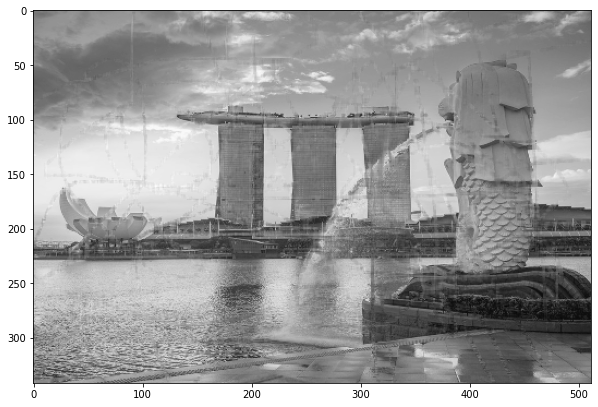

In [1235]:
plt.figure(figsize=(10,10))
plt.imshow(z9,cmap="gray") 